<a class="reference external" href="https://jupyter.designsafe-ci.org/hub/user-redirect/lab/tree/CommunityData/Training/Computational-Workflows-on-DesignSafe/Jupyter_Notebooks/Jupyter_Notebooks_OpenSees/runOps_Ex1a.py.Canti2D.Push.ipynb" target="_blank">
<img alt="Try on DesignSafe" src="https://raw.githubusercontent.com/DesignSafe-Training/pinn/main/DesignSafe-Badge.svg" /></a>

# OpenSeesPy in a Notebook
***Interactive OpenSeesPy Modeling, Analysis, and Automation — All in One Place***

by Silvia Mazzoni, DesignSafe, 2025

---
Jupyter Notebooks provide a powerful, flexible environment for working with OpenSees. Whether you're:

* Building models directly in Python using **OpenSeesPy**,
* Running **Tcl scripts** via command-line calls, or
* Submitting **HPC jobs** using the **Tapis API**,

you can handle every phase of your workflow—**scripting, visualization, submission, and post-processing**—within a single notebook.

With support for embedded plots, tables, and explanatory text alongside your code, Jupyter Notebooks let you create a **self-contained, shareable document** that combines input, output, and analysis.

For advanced workflows, you can even integrate **interactive widgets** (e.g., buttons, sliders, dropdowns) to build custom dashboards—ideal for parametric studies, batch execution, and data exploration. This transforms your notebook into a powerful interface for OpenSees-based research.

## Running OpenSees Interactively in a Notebook

Interactive OpenSees execution is supported for **sequential analyses** or methods that don’t rely on MPI. Running interactively is especially useful for:

* Testing your scripts,
* Verifying the simulation environment, and
* Iteratively debugging or refining your model.

We recommend using Jupyter Notebooks to run OpenSees interactively during model development. This setup makes it easy to experiment, edit, and visualize your results—all in one place.


## OpenSees Example 1a. 2D Elastic Cantilever Column -- Static Pushover

**Example File from the OpenSees Examples Manual Examples**

You can find the original Examples:<br>
https://opensees.berkeley.edu/wiki/index.php/Examples_Manual<br>
Original Examples by By Silvia Mazzoni & Frank McKenna, 2006, in Tcl<br>
Converted to OpenSeesPy by SilviaMazzoni, 2020<br>

---
    
## Introduction
Example 1a is a simple model of an elastic cantilever column. <br>
Objectives of Example 1a:
<li>overview of basic OpenSees input structure</li>
<li>coordinates, boundary conditions, element connectivity, nodal masses, nodal loads, etc.</li>
<li>two nodes, one element</li>
    
<img src="https://opensees.berkeley.edu/wiki/images/e/ec/Example1a_Push.GIF">

## Simulation Process

Each example script does the following:

### A. Build the model
<ol>
    <li>model dimensions and degrees-of-freedom</li>
    <li>nodal coordinates</li>
    <li>nodal constraints -- boundary conditions</li>
    <li>nodal masses</li>
    <li>elements and element connectivity</li>
    <li>recorders for output</li>
</ol>

### B. Define & apply gravity load
<ol>
    <li>nodal or element load</li>
    <li>static-analysis parameters (tolerances & load increments)</li>
    <li>analyze</li>
    <li>hold gravity loads constant</li>
    <li>reset time to zero</li>
</ol>

### C. Define and apply lateral load
<ul>
<li>Time Series and Load Pattern (nodal loads for static analysis, support ground motion for earthquake)</li>
<li>lateral-analysis parameters (tolerances and displacement/time increments)</li>
<i>Static Lateral-Load Analysis</i>
<li>define the displacement increments and displacement path</li>
</ul>

In [1]:
############################################################
#  EXAMPLE: 
#       Ex1a.Canti2D.Push.py
#          for OpenSeesPy
#  --------------------------------------------------------#
#  by: Silvia Mazzoni, 2020
#       silviamazzoni@yahoo.com
############################################################
# This file was obtained from a conversion of the updated Tcl script
# You can find the original Examples:
# https://opensees.berkeley.edu/wiki/index.php/Examples_Manual
# Original Examples by By Silvia Mazzoni & Frank McKenna, 2006, in Tcl
# Converted to OpenSeesPy by SilviaMazzoni, 2020
############################################################
# --------------------------------------------------------------------------------------------------
# Example 1. cantilever 2D
# static pushover analysis with gravity.
# all units are in kip, inch, second
# elasticBeamColumn ELEMENT
#			Silvia Mazzoni & Frank McKenna, 2006
#
#    ^Y
#    |
#    2       __ 
#    |         | 
#    |         | 
#    |         | 
#  (1)      36'
#    |         | 
#    |         | 
#    |         | 
#  =1=    ----  -------->X
#
#

In [2]:
# you may to do this once at the beginning of your session, and then comment it back
# %pip install OpenSeesPy

In [3]:
# Configure Python
import openseespy.opensees as ops
import numpy as numpy
import matplotlib.pyplot as plt
import os

### Move to user's home directory
This way you can save files to your home path -- you can't write to CommunityData

In [4]:
os.chdir(os.path.expanduser('~')) # ~ the tilda is a shortcut to the uers's home path.
cwd = os.getcwd()
print('current directory:',cwd)

current directory: /home/jupyter


### Create a temporary directory for our data and move to it
We want the directory to be within MyData.

In [5]:
tmpDir = 'MyData/tmp_training'
os.makedirs(tmpDir, exist_ok=True)
os.chdir(tmpDir)
cwd = os.getcwd()
print('new current directory:',cwd)

new current directory: /home/jupyter/MyData/tmp_training


In [6]:
LColList = [100,120,200,240,300,360,400,480]
#-----------------------------------------
dataDir=f'DataPYnb';                # set up name of data directory
os.makedirs(dataDir, exist_ok=True);    # create data directory

In [7]:
count = 0;
for Lcol in LColList:
    ops.wipe()

    # SET UP ----------------------------------------------------------------------------
    ops.wipe()     #  clear opensees model
    ops.model('basic','-ndm',2,'-ndf',3)     #  2 dimensions, 3 dof per node

    # define GEOMETRY -------------------------------------------------------------
    # nodal coordinates:
    ops.node(1,0,0)     #  node , X Y
    ops.node(2,0,Lcol)

    # Single point constraints -- Boundary Conditions
    ops.fix(1,1,1,1)     #  node DX DY RZ

    # nodal masses:
    ops.mass(2,5.18,0.,0.)     #  node , Mx My Mz, Mass=Weight/g.

    # Define ELEMENTS -------------------------------------------------------------
    # define geometric transformation: performs a linear geometric transformation of beam stiffness
    # and resisting force from the basic system to the global-coordinate system
    ops.geomTransf('Linear',1)     #  associate a tag to transformation

    # element elasticBeamColumn eleTag iNode jNode A E Iz transfTag
    ops.element('elasticBeamColumn',1,1,2,3600000000,4227,1080000,1)

    # Define RECORDERS -------------------------------------------------------------
    ops.recorder('Node','-file',f'{dataDir}/DFree_Lcol{Lcol}.out','-time','-node',2,'-dof',1,2,3,'disp')     #  displacements of free nodes
    ops.recorder('Node','-file',f'{dataDir}/DBase_Lcol{Lcol}.out','-time','-node',1,'-dof',1,2,3,'disp')     #  displacements of support nodes
    ops.recorder('Node','-file',f'{dataDir}/RBase_Lcol{Lcol}.out','-time','-node',1,'-dof',1,2,3,'reaction')     #  support reaction
    ops.recorder('Element','-file',f'{dataDir}/FCol_Lcol{Lcol}.out','-time','-ele',1,'globalForce')     #  element forces -- column
    ops.recorder('Element','-file',f'{dataDir}/DCol_Lcol{Lcol}.out','-time','-ele',1,'deformation')     #  element deformations -- column


    # define GRAVITY -------------------------------------------------------------
    ops.timeSeries('Linear',1)     # timeSeries Linear 1;
    ops.pattern('Plain',1,1) # 
    ops.load(2,0.,-2000.,0.)     #  node , FX FY MZ -- superstructure-weight
    ops.wipeAnalysis()     # adding this to clear Analysis module 
    ops.constraints('Plain')     #  how it handles boundary conditions
    ops.numberer('Plain')     #  renumber dofs to minimize band-width (optimization), if you want to
    ops.system('BandGeneral')     #  how to store and solve the system of equations in the analysis
    ops.test('NormDispIncr',1.0e-8,6)     #  determine if convergence has been achieved at the end of an iteration step
    ops.algorithm('Newton')     #  use Newtons solution algorithm: updates tangent stiffness at every iteration
    ops.integrator('LoadControl',0.1)     #  determine the next time step for an analysis,   apply gravity in 10 steps
    ops.analysis('Static')     #  define type of analysis static or transient
    ops.analyze(10)     #  perform gravity analysis
    ops.loadConst('-time',0.0)     #  hold gravity constant and restart time

    # define LATERAL load -------------------------------------------------------------
    ops.timeSeries('Linear',2)     # timeSeries Linear 2;
    ops.pattern('Plain',2,2) # 
    ops.load(2,2000.,0.0,0.0)     #  node , FX FY MZ -- representative lateral load at top node

    # pushover: diplacement controlled static analysis
    ops.integrator('DisplacementControl',2,1,0.1)     #  switch to displacement control, for node 11, dof 1, 0.1 increment
    ops.analyze(1000)     #  apply 100 steps of pushover analysis to a displacement of 10

    print(f'Analysis-{count} execution done')

    count +=1
print(f"ALL DONE!!!")

Analysis-0 execution done
Analysis-1 execution done
Analysis-2 execution done
Analysis-3 execution done
Analysis-4 execution done
Analysis-5 execution done
Analysis-6 execution done
Analysis-7 execution done
ALL DONE!!!


In [8]:
# check paths:
print('relative path:',os.path.expanduser(dataDir))
print('absolute path:',os.path.abspath(dataDir))

print('current directory:',os.getcwd())

relative path: DataPYnb
absolute path: /home/jupyter/MyData/tmp_training/DataPYnb
current directory: /home/jupyter/MyData/tmp_training


End of Run


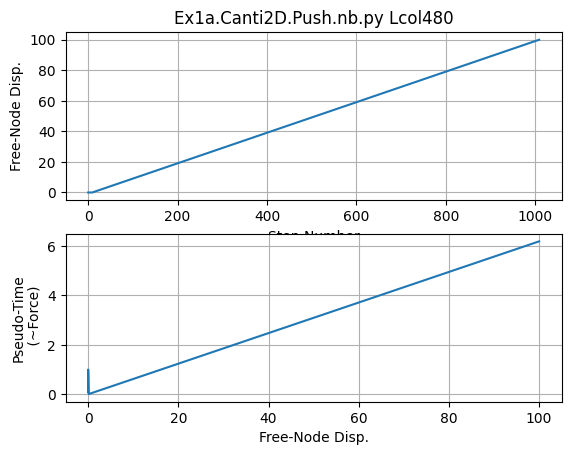

In [9]:
# Plot Results
ops.wipe()
plt.close('all')
fname3 = f'{dataDir}/DFree_Lcol{Lcol}.out'
dataDFree = numpy.loadtxt(fname3)
plt.subplot(211)
plt.title(f'Ex1a.Canti2D.Push.nb.py Lcol{Lcol}')
plt.grid(True)
plt.plot(dataDFree[:,1])
plt.xlabel('Step Number')
plt.ylabel(f'Free-Node Disp.')
plt.subplot(212)
plt.grid(True)
plt.plot(dataDFree[:,1],dataDFree[:,0])
plt.xlabel('Free-Node Disp.')
plt.ylabel('Pseudo-Time\n (~Force)')
print('End of Run')

In [10]:
print('done!')

done!
